# <font color=#E67E22>**Measure fairness in healtcare-related database using the Aequitas toolkit**</font>

***Simone Callegarin*** - **932342** - **232592** - simone.callegarin@mail.polimi.it

Link to the [**github repository of the project**](https://github.com/SimoneCallegarin/TIS_project).

## <font color=#E59866>**Steps**</font>


*   Setting up the Developement Environment
*   Data Description
*   Data Analisys
*   Predictive Algorithm
*   Data Preprocessing
*   Upload Data into the Github Repository
*   Auditing Fairness of the Model using Aequitas


## <font color=#5DADE2>Setting up the Developement Environment</font>
   

All the necessary imports in order to make the notebook works:

In [117]:
%%capture
!pip install aequitas
# Import Pandas, a data analysis and manipulation tool
import pandas as pd
# Import Seaborn, a data visualization library based on matplotlib
import seaborn as sns
# Import Numpy, a package for scientific computing in Python
import numpy as np
# Import the Random Forest Classifier, a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset
from sklearn.ensemble import RandomForestClassifier
# Import train_test_split, to split arrays or matrices into random train and test subsets
from sklearn.model_selection import train_test_split
# Import the metrics to evaluate the classifier
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score
# Import Aequitas preprocessing tool for the dataframe
from aequitas.preprocessing import preprocess_input_df
# Import Aequitas Group
from aequitas.group import Group
# Import Aequitas Bias 
from aequitas.bias import Bias
# Import Aequitas Fairness
from aequitas.fairness import Fairness
# Import Aequitas Plot
import aequitas.plot as ap
# Update Pillow for graphs and images
!pip install Pillow==9.0.0
# Import PyPlot, a state-based interface to matplotlib that provides an implicit, MATLAB-like, way of plotting.
import matplotlib.pyplot as plt
# Import PlotLy to do other graph plotting
import plotly.graph_objects as go
# Import the requests module to send a PUT request
import requests
# Import the base64 module for encoding a file to base64
import base64


pd.options.mode.chained_assignment = None
aq_palette = sns.diverging_palette(225, 35, n=2)
%matplotlib inline

Importing all that is needed in order to retrive the GitHub token that must be saved in a *json* file under the key *data_api_key*:

In [118]:
from google.colab import files
import io
import json

# Use files.upload to produce the "Choose Files" button below, then select your file.
uploaded = files.upload()

# Use io.BytesIO to decode the file, then json.load to open it.
file = io.BytesIO(uploaded['APIkey.json'])

# API token of the github repository
githubToken = json.load(file)['data_api_key']

Saving APIkey.json to APIkey.json


## <font color=#5DADE2>Data</font>

### <font color=#85C1E9>Dataset</font>
The original Diabetes Dataset has been taken from [Diabetes 130-Hospitals](https://www.openml.org/search?type=data&status=active&id=43903).

This dataset represents 10 years of clinical care at 130 U.S. hospitals and delivery networks, collected from 1999 to 2008. 
Each record represents the hospital admission record for a patient diagnosed with diabetes whose stay lasted between one to fourteen days. 
The features describing each encounter include demographics, diagnoses, diabetic medications, number of visits in the year preceding the encounter, and payer information, as well as whether the patient was readmitted after release, and whether the readmission occurred within 30 days of the release.

The original "Diabetes 130-Hospitals" dataset was collected by Beata Strack, Jonathan P. DeShazo, Chris Gennings, Juan L. Olmo, Sebastian Ventura, Krzysztof J. Cios, and John N. Clore in 2014.

---

It was provided an already preprocessed version of the original one that can be found [here](https://www.kaggle.com/datasets/mathchi/diabetes-data-set).

All patients here are females at least 21 years old of Pima Indian heritage.

Here is the meaning of what the values of each column are referring:

* Pregnancies: Number of times pregnant
* Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
* BloodPressure: Diastolic blood pressure (mm Hg)
* SkinThickness: Triceps skin fold thickness (mm)
* Insulin: 2-Hour serum insulin (mu U/ml)
* BMI: Body mass index (weight in kg/(height in m)^2)
* DiabetesPedigreeFunction: Diabetes pedigree function
* Age: Age (years)
* Outcome: Class variable (1 if diabetic, 0 otherwise)


#### <font color=#85C1E9>Dataset download</font>
Data has been taken from the csv available online in [github](https://github.com/SimoneCallegarin/TIS_project/blob/main/raw_data/diabetes.csv) into a table

In [174]:
df = pd.read_csv("https://raw.githubusercontent.com/SimoneCallegarin/TIS_project/master/raw_data/diabetes.csv")
df.columns.values[0] = 'entity_id'

The first five rows of the downloaded dataset:

In [175]:
df.head()

,entity_id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,AgeCategory
0,0,6.0,148,72.0,35.0,30.5,33.6,0.627,50.0,1,1
1,1,1.0,85,66.0,29.0,30.5,26.6,0.351,31.0,0,1
2,2,8.0,183,64.0,23.0,30.5,23.3,0.672,32.0,1,1
3,3,1.0,89,66.0,23.0,94.0,28.1,0.167,21.0,0,0
4,4,0.0,137,40.0,35.0,168.0,43.1,0.374,33.0,1,1


The last five rows of the downloaded dataset:

In [176]:
df.tail()

,entity_id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,AgeCategory
758,763,10.0,101,76.0,23.0,180.0,32.9,0.171,63.0,0,1
759,764,2.0,122,70.0,27.0,30.5,36.8,0.340,27.0,0,1
760,765,5.0,121,72.0,23.0,112.0,26.2,0.245,30.0,0,1
761,766,1.0,126,60.0,23.0,30.5,30.1,0.349,47.0,1,1
762,767,1.0,93,70.0,31.0,30.5,30.4,0.315,23.0,0,0


Drop *entity_id* column that isn't relevant for further analisys, in order to keep only relevant columns:

In [177]:
df = df[[ 'Pregnancies', 'Glucose',	'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome', 'AgeCategory' ]]

#### <font color=#85C1E9>Data Description</font>
An exhaustive description of the dataset, with a first analisys on data correlation

Brief description of how the dataset is structured:

In [123]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,763.0,3.788991,3.275421,0.000,1.0000,3.000,6.000,13.000
Glucose,763.0,121.686763,30.535641,44.000,99.0000,117.000,141.000,199.000
BloodPressure,763.0,72.226737,11.142938,38.000,64.0000,72.000,80.000,106.000
SkinThickness,763.0,26.256881,7.482583,10.000,23.0000,23.000,31.000,45.000
Insulin,763.0,71.029161,59.760128,14.000,30.5000,31.250,105.000,272.000
BMI,763.0,32.194495,6.411094,18.200,27.5000,32.000,36.300,50.000
DiabetesPedigreeFunction,763.0,0.408339,0.215128,0.078,0.2435,0.374,0.548,0.997
Age,763.0,32.787680,11.064569,21.000,24.0000,29.000,40.000,66.000
Outcome,763.0,0.348624,0.476847,0.000,0.0000,0.000,1.000,1.000
AgeCategory,763.0,0.653997,0.476006,0.000,0.0000,1.000,1.000,1.000


Number of people that were diagnosed with diabetes is identified by the class variable *Outcome* with value 1, else with 0:

In [124]:
print(df['Outcome'].value_counts())

0    497
1    266
Name: Outcome, dtype: int64


An histogram representing the difference in number between who is a diabetic and who is not:

In [125]:
labels = ['Non-Diabetes','Diabetes']
fig = go.Figure([go.Bar(x=labels, y=df['Outcome'].value_counts())])
fig.show()

A pie chart representing the difference in number between who is a diabetic and who is not:

In [126]:
fig = go.Figure(data=[go.Pie(labels=labels, values=df['Outcome'].value_counts())])
fig.show()

Histograms of each attribute:

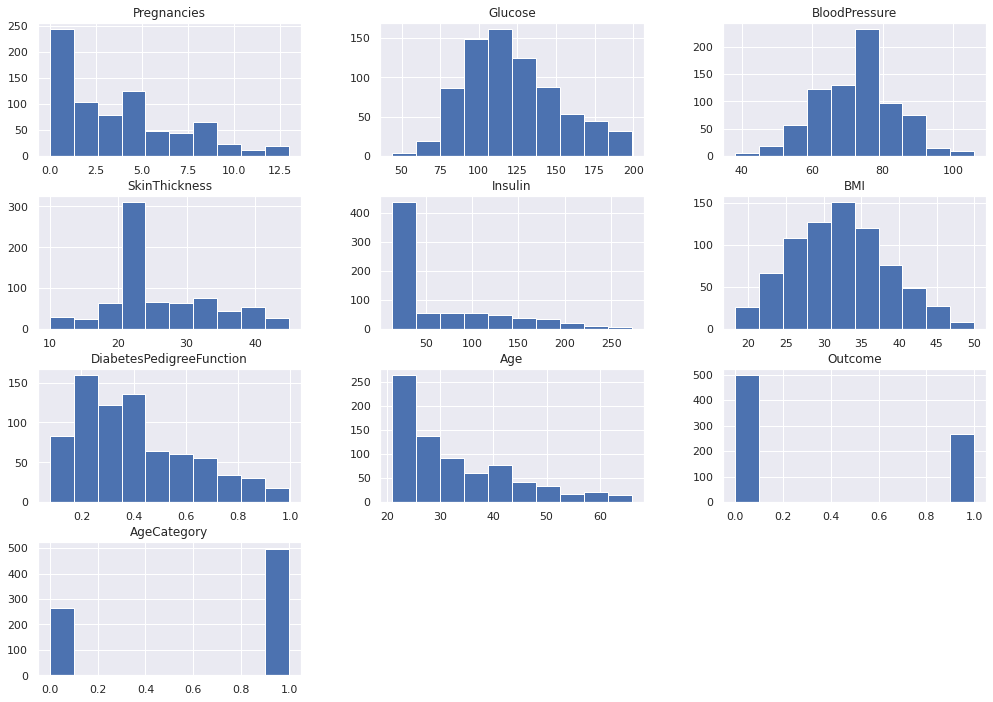

In [127]:
df.hist(figsize=(17,12))
plt.show()

An heatmap for correlation of parameters that permits to see how much different attributes are correlated between each other.

Values closer to 1 means higher correlation

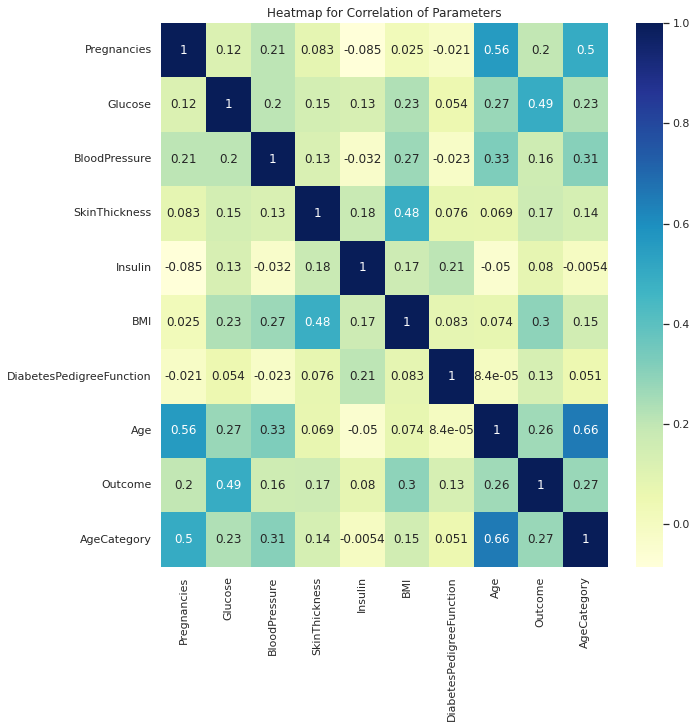

In [178]:
corr = df[df.columns].corr()
sns.heatmap(corr, cmap="YlGnBu", annot = True)
plt.title('Heatmap for Correlation of Parameters')
sns.set(rc={'figure.figsize':(10,10)})
plt.show()

From the heatmap we can see that there are few attributes which are having a mild correlation with the *Outcome*, for example *Glucose*, *BMI* and our sensitive attribute, the *AgeCategory*

This kind of correlation is easily discernible from a kernel density estimate (KDE) plot, that permits to compare the distribution of each attribute with the *Outcome* one

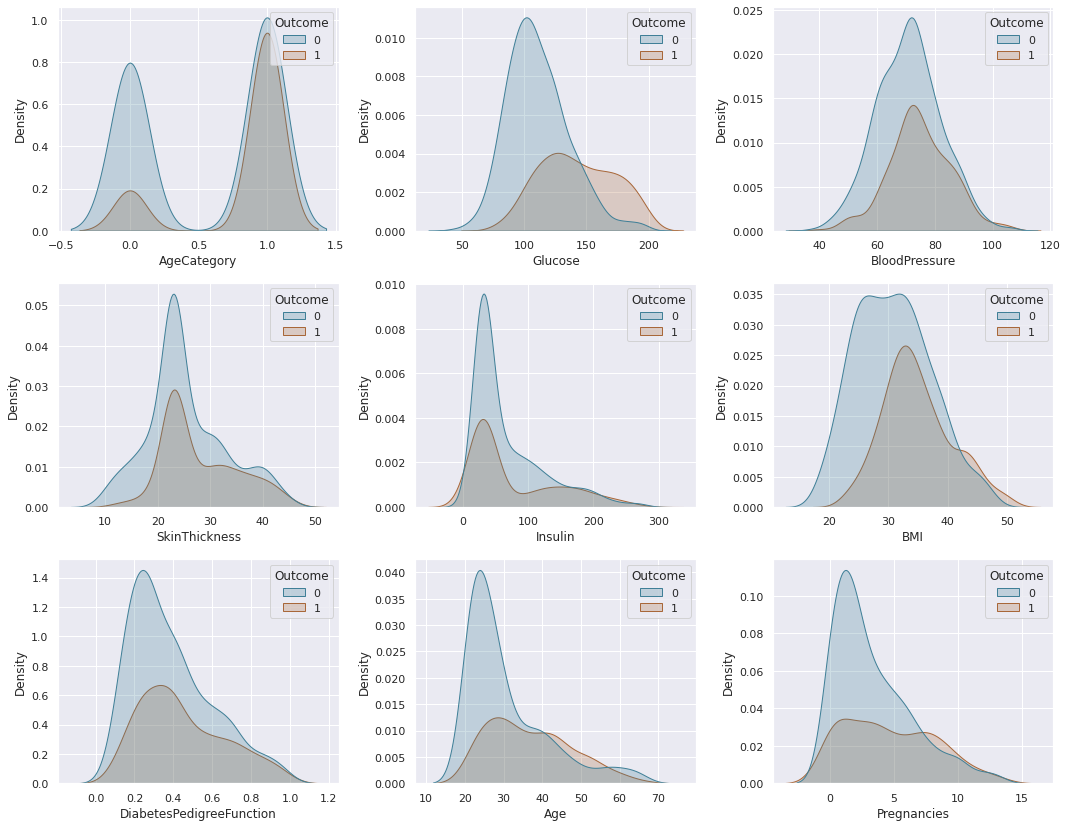

In [179]:
plt.figure(figsize=(15,15))
plt.subplot(4,3,1)
sns.kdeplot(data=df, x="AgeCategory", hue="Outcome", fill=True, palette=aq_palette)
plt.subplot(4,3,2)
sns.kdeplot(data=df, x="Glucose", hue="Outcome", fill=True, palette=aq_palette)
plt.subplot(4,3,3)
sns.kdeplot(data=df, x="BloodPressure", hue="Outcome", fill=True, palette=aq_palette)
plt.subplot(4,3,4)
sns.kdeplot(data=df, x="SkinThickness", hue="Outcome", fill=True, palette=aq_palette)
plt.subplot(4,3,5)
sns.kdeplot(data=df, x="Insulin", hue="Outcome", fill=True, palette=aq_palette)
plt.subplot(4,3,6)
sns.kdeplot(data=df, x="BMI", hue="Outcome", fill=True, palette=aq_palette)
plt.subplot(4,3,7)
sns.kdeplot(data=df, x="DiabetesPedigreeFunction", hue="Outcome", fill=True, palette=aq_palette)
plt.subplot(4,3,8)
sns.kdeplot(data=df, x="Age", hue="Outcome", fill=True, palette=aq_palette)
plt.subplot(4,3,9)
sns.kdeplot(data=df, x="Pregnancies", hue="Outcome", fill=True, palette=aq_palette)
plt.tight_layout()

Focusing on the *AgeCategory* distribution is very easy to notice how much the *Outcome* depend on that attribute

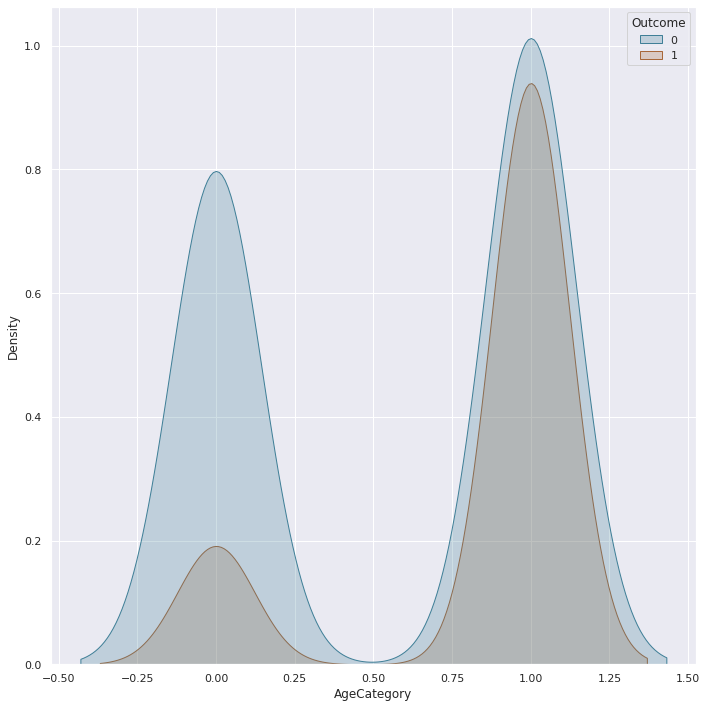

In [180]:
plt.figure(figsize=(10,10))
sns.kdeplot(data=df, x="AgeCategory", hue="Outcome", fill=True, palette=aq_palette)
plt.tight_layout()

#### <font color=#85C1E9>Checking for Null Values or Missing Values</font>
In order to perform the Random Forest Classifier correctly it's necessary to check whether the dataset contains or not *Null* or *Missing* values

In [131]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
AgeCategory                 0
dtype: int64

In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 763 entries, 0 to 762
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               763 non-null    float64
 1   Glucose                   763 non-null    int64  
 2   BloodPressure             763 non-null    float64
 3   SkinThickness             763 non-null    float64
 4   Insulin                   763 non-null    float64
 5   BMI                       763 non-null    float64
 6   DiabetesPedigreeFunction  763 non-null    float64
 7   Age                       763 non-null    float64
 8   Outcome                   763 non-null    int64  
 9   AgeCategory               763 non-null    int64  
dtypes: float64(7), int64(3)
memory usage: 59.7 KB


The check is over, the analisys reported that there were no missing or null values.

## <font color=#5DADE2>Predictive Algorithm</font>

### <font color=#85C1E9>Random Forest Classifier</font>
A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. 

Documentation can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html/).

Define x and y are respectively the dataframe without the *Outcome* and the *Outcome* values only:

In [182]:
x = df.drop(['Outcome'],axis=1)
y = df.Outcome

Define the test and training sets.

The test set size is defined on the 20% of the dataframe, the rest (80%) is assigned to the training set:

In [183]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.2)

This is the shape in number of entities of each training and test set:

In [184]:
print("x_train ->",x_train.shape)
print("x_test ->",x_test.shape)
print("\ny_train ->",y_train.shape)
print("y_test ->",y_test.shape)

x_train -> (610, 9)
x_test -> (153, 9)

y_train -> (610,)
y_test -> (153,)


Run the Random Forest Classifier on the training set previously originated:

In [185]:
rf = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf.fit(x_train, y_train)

RandomForestClassifier(random_state=0)

Predictions made by the Random Forest Clasifier on the test set:

In [186]:
rf_prediction = rf.predict(x_test)

Define some metrics to evaluate the goodness of the model: 

In [187]:
c = confusion_matrix(y_test,rf_prediction)
a = accuracy_score(y_test,rf_prediction)
p = precision_score(y_test,rf_prediction)
r = recall_score(y_test,rf_prediction)

In [188]:
print('Accuracy', a*100)

Accuracy 78.43137254901961


In [189]:
print('Confusion Matrix:\n', c)

Confusion Matrix:
 [[87 18]
 [15 33]]


In [190]:
print('Recall:', r*100)

Recall: 68.75


In [191]:
print('Precision:', p*100)

Precision: 64.70588235294117


Graphical representation of the confusion matrix:

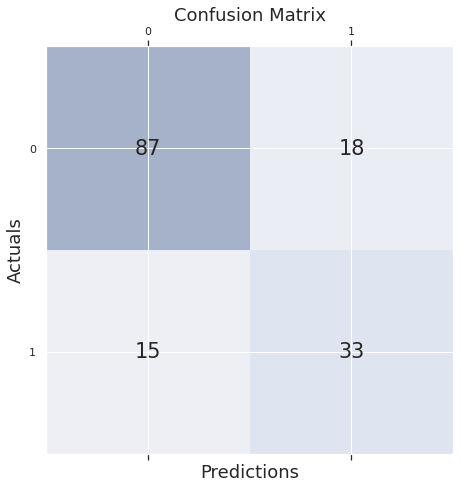

In [192]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(c, cmap=plt.cm.Blues, alpha=0.3)
for i in range(c.shape[0]):
    for j in range(c.shape[1]):
        ax.text(x=j, y=i,s=c[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

## <font color=#5DADE2>Preprocessing</font>
The next step is to pre-process the Data provided in order to assess the fairness of the Dataset


1. *Outcome* column has been renamed in *score*.

2. *AgeCategory* column has been renamed with *label_value* because it will be the attribute on which to search for discrimination.

3. The first column that was left unnamed has been renemed in *entity_id*, a reserved column name that permit us to refer to each entity.

4. Continuous values are discretized by Aequitas that will first bin the data into quartiles and then create crosstabs with the newly defined categories.

5. The final table has been reordered with all the necessary attributes.

In [193]:
x_test['score'] = rf_prediction
x_test['Outcome'] = y_test
df = x_test

In [194]:
(df['Outcome'] == df['score']).value_counts()

True     120
False     33
dtype: int64

In [195]:
df = df.rename( columns={ 'Outcome' : 'label_value' } )

other_attributes = ['score', 'label_value', 'Pregnancies', 'Glucose',	'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'	]

processed_df, _ = preprocess_input_df(df[other_attributes])

processed_df['AgeCategory'] = df['AgeCategory']

processed_df.loc[processed_df['AgeCategory'] != 1,'AgeCategory'] = str(0)
processed_df.loc[processed_df['AgeCategory'] == 1 ,'AgeCategory'] = str(1)

processed_df.head(10).style.hide(axis='index')

score,label_value,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,AgeCategory
1,0,3.00-5.00,141.00-197.00,64.00-72.00,10.00-23.00,16.00-30.50,28.40-32.70,0.08-0.24,37.00-65.00,1
1,1,1.00-3.00,115.00-141.00,64.00-72.00,10.00-23.00,16.00-30.50,28.40-32.70,0.57-0.96,24.00-28.00,1
1,1,5.00-13.00,141.00-197.00,72.00-80.00,23.00-32.00,16.00-30.50,28.40-32.70,0.34-0.57,37.00-65.00,1
1,1,3.00-5.00,141.00-197.00,80.00-106.00,32.00-45.00,105.00-265.00,37.50-47.90,0.34-0.57,28.00-37.00,1
1,0,0.00-1.00,141.00-197.00,72.00-80.00,32.00-45.00,105.00-265.00,37.50-47.90,0.24-0.34,24.00-28.00,1
1,1,5.00-13.00,99.00-115.00,80.00-106.00,32.00-45.00,16.00-30.50,37.50-47.90,0.57-0.96,37.00-65.00,1
0,0,1.00-3.00,57.00-99.00,44.00-64.00,23.00-32.00,16.00-30.50,19.30-28.40,0.57-0.96,21.00-24.00,0
1,0,0.00-1.00,115.00-141.00,72.00-80.00,10.00-23.00,16.00-30.50,28.40-32.70,0.57-0.96,28.00-37.00,1
1,0,1.00-3.00,99.00-115.00,80.00-106.00,10.00-23.00,16.00-30.50,37.50-47.90,0.57-0.96,37.00-65.00,1
0,0,5.00-13.00,115.00-141.00,64.00-72.00,10.00-23.00,16.00-30.50,19.30-28.40,0.08-0.24,28.00-37.00,1


The result of this preprocessing phase is a table with the following dimensions:

In [196]:
processed_df.shape

(153, 11)

## <font color=#5DADE2>Predicted Data Analisys</font>


Analisys on the distribution of the *label_value* and the *score* over the sensitive attribute *AgeCategory*.

The graphs plotted focus on the difference in distribution between the predicted number of diabetic people and the real number of diabetic in the dataset with respect to the *AgeCategory* they belong:

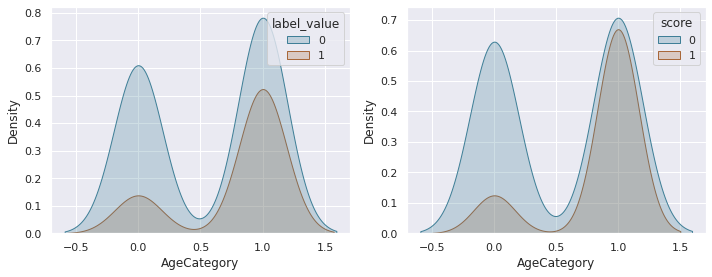

In [197]:
plt.figure(figsize=(15,15))
plt.subplot(4,3,1)
sns.kdeplot(data=df, x="AgeCategory", hue="label_value", fill=True, palette=aq_palette)
plt.subplot(4,3,2)
sns.kdeplot(data=df, x="AgeCategory", hue="score", fill=True, palette=aq_palette)
plt.tight_layout()

The first graph present the distribution of people that really suffer from diabetes, while the second highlight the distribution of predicted diabetic people by our model.

It is evident that the graphs highlight a difference in density between the predicted number of diabetics and the real one for the people belonging to the *AgeCategory* of 1, i.e. people that are over 25 years old.

This can be interpreted as a probable bias of our predictive model that we will investigate further on.

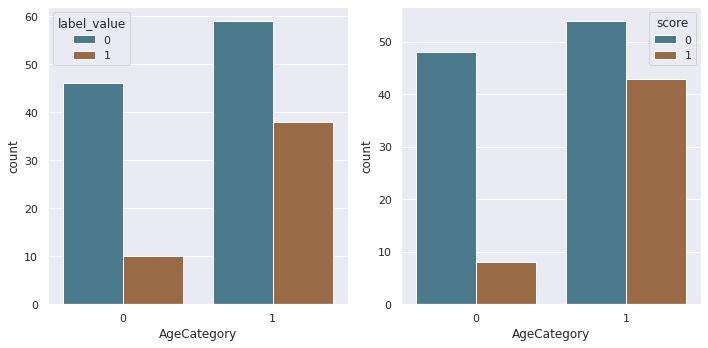

In [200]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
by_AgeCategory = sns.countplot(x="AgeCategory", hue="label_value", data=df, palette=aq_palette)
plt.subplot(1,2,2)
by_AgeCategory = sns.countplot(x="AgeCategory", hue="score", data=df, palette=aq_palette)
plt.tight_layout()

## <font color=#5DADE2>Upload</font>
Upload the *csv* file with the new preprocessed table into the [github repository](https://github.com/SimoneCallegarin/TIS_project/blob/main/data/diabetes.csv)

In [201]:
df.to_csv('diabetes.csv')

githubAPIURL = "https://api.github.com/repos/SimoneCallegarin/TIS_project/contents/data/diabetes.csv"

r_get = requests.get(githubAPIURL)
sha = r_get.json()['sha']

with open('diabetes.csv', "rb") as f:

    encodedData = base64.b64encode(f.read())

    headers = {
        "Authorization": f'''Bearer {githubToken}''',
        "Content-type": "application/vnd.github+json"
    }
    data = {
        "message": "Upload processed data", # commit message here.
        "content": encodedData.decode("utf-8"),
        "sha": sha
    }

    r = requests.put(githubAPIURL, headers=headers, json=data)
  
    # print(r.text) # Printing the response   

## <font color=#5DADE2>Dataframe Formatting</font>
In this section some functions are defined to format the dataframes, in order to improve their readability and to facilitate their comprehension

### <font color=#85C1E9>Text formatting</font>

Paints FALSE in red and TRUE in green text:

In [202]:
def color_true_false(value):
    if type(value) != type(''):
        color = 'red' if value < 1 else 'green'
        return 'color: {}'.format(color)

Paints values that are equal to 1 with green text:

In [203]:
def color_val(val):
  if type(val) != type(''):
    if val == 1:
      color = 'green'
      return 'color: {}'.format(color)

### <font color=#85C1E9>Table formatting</font>

Shades the rows of the table with a gray scale color for each *attribute_name* group that was defined during the preprocessing phase.

In [204]:
def highlight_gray(value):
  if type(value) != type(''):
    if value.attribute_name == 'Pregnancies':
        return ['background-color: 	#CCCCCC'] * len(value)
    if value.attribute_name == 'Glucose':
        return ['background-color: 	#BFBFBF'] * len(value)
    if value.attribute_name == 'BloodPressure':
        return ['background-color: 	#B3B3B3'] * len(value)
    if value.attribute_name == 'SkinThickness':
        return ['background-color: 	#A6A6A6'] * len(value)
    if value.attribute_name == 'Insulin':
        return ['background-color: 	#999999'] * len(value)
    if value.attribute_name == 'BMI':
        return ['background-color:  #A6A6A6'] * len(value)
    if value.attribute_name == 'DiabetesPedigreeFunction':
        return ['background-color: 	#B3B3B3'] * len(value)
    if value.attribute_name == 'Age':
        return ['background-color: 	#BFBFBF'] * len(value)
    if value.attribute_name == 'AgeCategory':
        return ['background-color: 	#CCCCCC'] * len(value)

Shades the rows of the table with a light blue scale color for each *attribute_name* group that was defined during the preprocessing phase.

In [205]:
def highlight_blue(value):
  if type(value) != type(''):
    if value.attribute_name == 'Pregnancies':
        return ['background-color: 	#f5f9fc'] * len(value)
    if value.attribute_name == 'Glucose':
        return ['background-color: 	#ebf3fa'] * len(value)
    if value.attribute_name == 'BloodPressure':
        return ['background-color: 	#e2edf8'] * len(value)
    if value.attribute_name == 'SkinThickness':
        return ['background-color:  #d8e7f5'] * len(value)
    if value.attribute_name == 'Insulin':
        return ['background-color: 	#cfe2f3'] * len(value)
    if value.attribute_name == 'BMI':
        return ['background-color: 	#c5dcf1'] * len(value)
    if value.attribute_name == 'DiabetesPedigreeFunction':
        return ['background-color: 	#bbd6ee'] * len(value)
    if value.attribute_name == 'Age':
        return ['background-color: 	#b2d0ec'] * len(value)
    if value.attribute_name == 'AgeCategory':
        return ['background-color: 	#a8caea'] * len(value)

Formats text and background for each row pof the dataframe with black text, for the background a sequence of light blue shades for each group and adding a gradient to the dataframes containing absolute metrics.

In [206]:
def format_blue_table(tab_style):
    tab_style.set_properties(**{'color': 'black'})
    tab_style.set_properties(**{'color': 'navy'}, subset = ['attribute_value'])
    tab_style.apply(highlight_blue, axis = 1)

Formats text and background for each row of the dataframe with black text and for the background a sequence of gray shades for each group.

In [207]:
def format_gray_table(tab_style):
    tab_style.set_properties(**{'color': 'black'}, subset = ['attribute_name'])
    tab_style.set_properties(**{'color': 'navy'}, subset = ['attribute_value'])
    tab_style.apply(highlight_gray, axis = 1)

## <font color=#5DADE2>Auditing a Single Model using [Aequitas](http://www.datasciencepublicpolicy.org/projects/aequitas/)</font>

Practitioners face the challenge of determining whether or not such patterns reflect bias or not. The fact that there are multiple ways to measure bias adds complexity to the decision-making process. With Aequitas, we provide a tool that automates the reporting of various fairness metrics to aid in this process.

Applying Aequitas progammatically is a three step process represented by three python classes: 

`Group()`: Define groups 

`Bias()`: Calculate disparities

`Fairness()`: Assert fairness

Each class builds on the previous one expanding the output DataFrame.


The **`get_crosstabs()`** method tabulates a confusion matrix for each subgroup and calculates commonly used metrics.

It also provides counts by group and group prevelances.

In [157]:
g = Group()

xtab, _ = g.get_crosstabs(processed_df)

In [210]:
abs_metrics = g.list_absolute_metrics(xtab)

### <font color=#5DADE2>Group Counts Calculated</font>



| Count Type | Column Name |
| --- | --- |
| False Positive Count | 'fp' |
| False Negative Count | 'fn' |
| True Negative Count | 'tn' |
| True Positive Count | 'tp' |
| Predicted Positive Count | 'pp' |
| Predicted Negative Count | 'pn' |
| Count of Negative Labels in Group | 'group_label_neg' |
| Count of Positive Labels in Group | 'group_label_pos' | 
| Group Size | 'group_size'|
| Total Entities | 'total_entities' |

In [159]:
group_measures = xtab[[col for col in xtab.columns if col not in abs_metrics]]
group_measures = group_measures[[col for col in group_measures if col not in ['model_id','score_threshold','k']	]]
group_measures_style = group_measures.style

In [160]:
format_blue_table(group_measures_style)
group_measures_style

,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,Pregnancies,0.00-1.00,13,37,6,6,31,7,13,37,50,153
1,Pregnancies,1.00-3.00,9,28,2,3,25,7,10,27,37,153
2,Pregnancies,3.00-5.00,8,20,4,3,17,4,7,21,28,153
3,Pregnancies,5.00-13.00,21,17,6,3,14,15,18,20,38,153
4,Glucose,115.00-141.00,10,27,6,4,23,4,8,29,37,153
5,Glucose,141.00-197.00,32,5,9,3,2,23,26,11,37,153
6,Glucose,57.00-99.00,0,39,0,4,35,0,4,35,39,153
7,Glucose,99.00-115.00,9,31,3,4,27,6,10,30,40,153
8,BloodPressure,44.00-64.00,7,33,2,5,28,5,10,30,40,153
9,BloodPressure,64.00-72.00,12,27,5,4,23,7,11,28,39,153


### <font color=#5DADE2>Absolute Metrics Calculated</font>



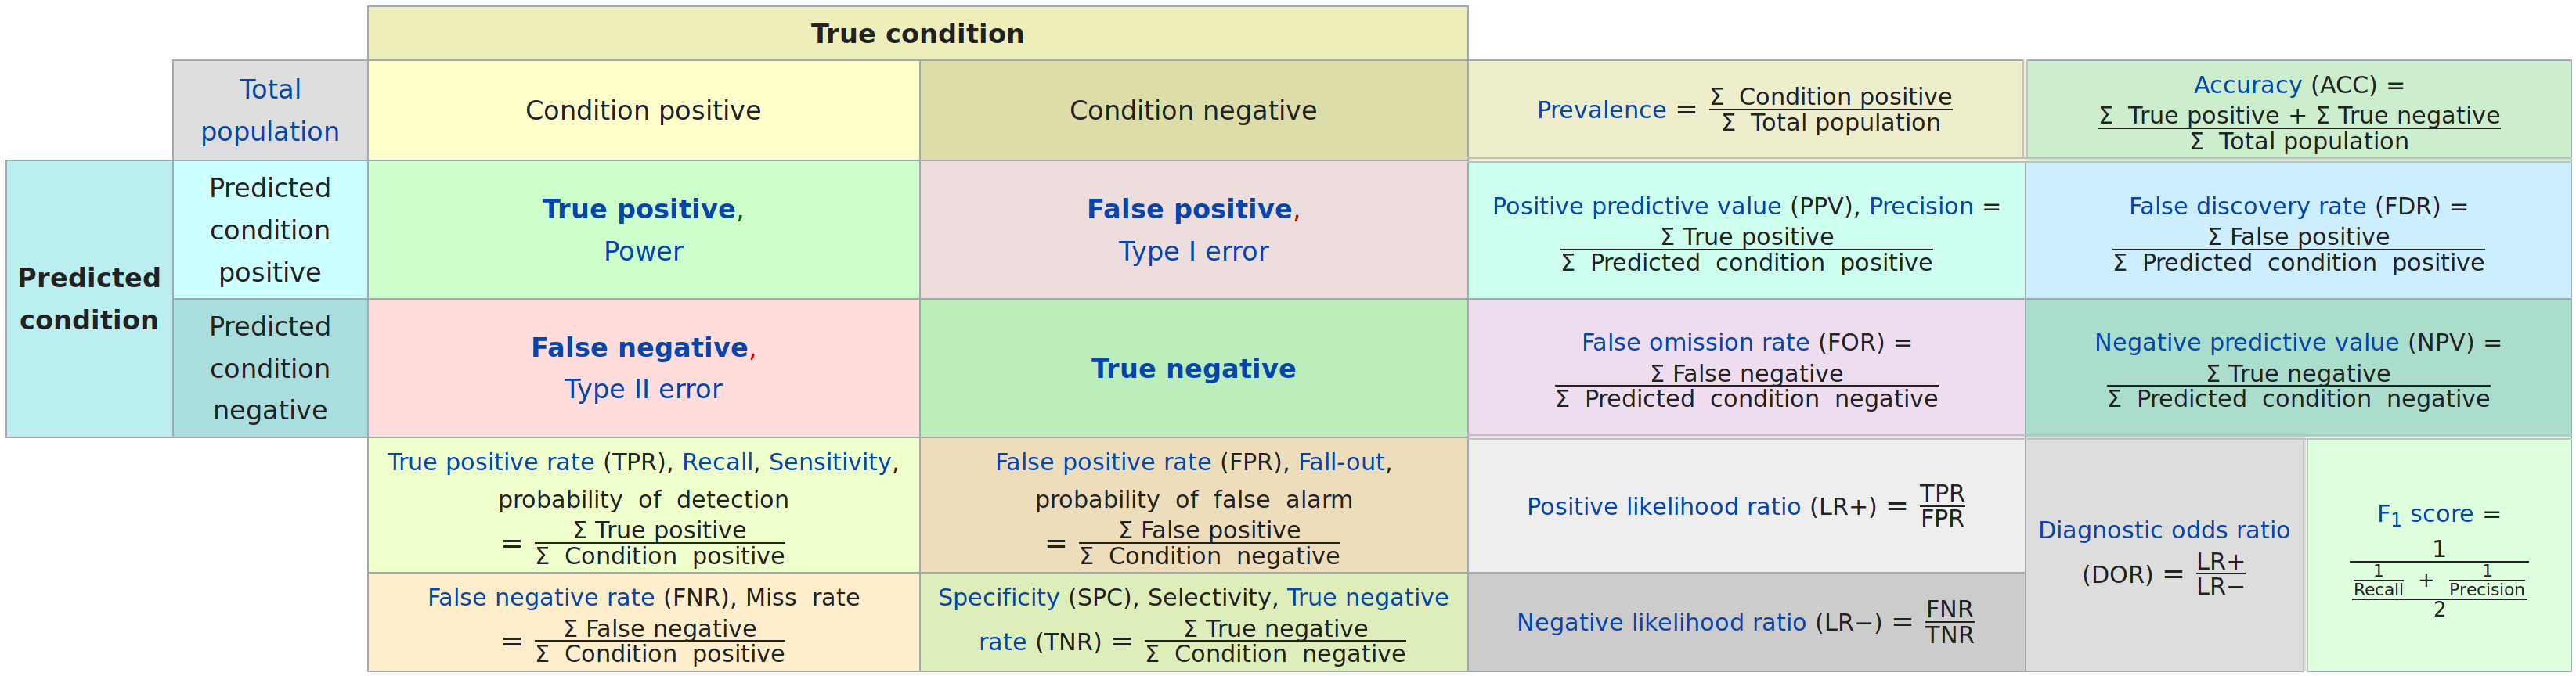


In [209]:
print(abs_metrics)

['tpr', 'tnr', 'for', 'fdr', 'fpr', 'fnr', 'npv', 'precision', 'ppr', 'pprev', 'prev']


| Metric | Column Name |
| --- | --- |
| True Positive Rate | 'tpr' |
| True Negative Rate | 'tnr' |
| False Omission Rate | 'for' |
| False Discovery Rate | 'fdr' |
| False Positive Rate | 'fpr' |
| False Negative Rate | 'fnr' |
| Negative Predictive Value | 'npv' |
| Precision | 'precision' |
| Predicted Positive Ratio$_k$ | 'ppr' |
| Predicted Positive Ratio$_g$ | 'pprev' |
| Group Prevalence | 'prev' |

In [161]:
absolute_metrics = xtab[['attribute_name', 'attribute_value'] + abs_metrics]

In [162]:
absolute_metrics['fdr'] = absolute_metrics['fdr'].replace(np.nan,0)
absolute_metrics['precision'] = absolute_metrics['precision'].replace(np.nan,1)

In [163]:
absolute_metrics_style = absolute_metrics.round(2).style
format_blue_table(absolute_metrics_style)
absolute_metrics_style.background_gradient(axis=0, subset = abs_metrics)
absolute_metrics_style

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,Pregnancies,0.00-1.00,0.540000,0.840000,0.160000,0.460000,0.160000,0.460000,0.840000,0.540000,0.250000,0.260000,0.260000
1,Pregnancies,1.00-3.00,0.700000,0.930000,0.110000,0.220000,0.070000,0.300000,0.890000,0.780000,0.180000,0.240000,0.270000
2,Pregnancies,3.00-5.00,0.570000,0.810000,0.150000,0.500000,0.190000,0.430000,0.850000,0.500000,0.160000,0.290000,0.250000
3,Pregnancies,5.00-13.00,0.830000,0.700000,0.180000,0.290000,0.300000,0.170000,0.820000,0.710000,0.410000,0.550000,0.470000
4,Glucose,115.00-141.00,0.500000,0.790000,0.150000,0.600000,0.210000,0.500000,0.850000,0.400000,0.200000,0.270000,0.220000
5,Glucose,141.00-197.00,0.880000,0.180000,0.600000,0.280000,0.820000,0.120000,0.400000,0.720000,0.630000,0.860000,0.700000
6,Glucose,57.00-99.00,0.000000,1.000000,0.100000,0.000000,0.000000,1.000000,0.900000,1.000000,0.000000,0.000000,0.100000
7,Glucose,99.00-115.00,0.600000,0.900000,0.130000,0.330000,0.100000,0.400000,0.870000,0.670000,0.180000,0.220000,0.250000
8,BloodPressure,44.00-64.00,0.500000,0.930000,0.150000,0.290000,0.070000,0.500000,0.850000,0.710000,0.140000,0.180000,0.250000
9,BloodPressure,64.00-72.00,0.640000,0.820000,0.150000,0.420000,0.180000,0.360000,0.850000,0.580000,0.240000,0.310000,0.280000


### <font color=#5DADE2>Bias</font>

In [164]:
b = Bias()
bdf = b.get_disparity_predefined_groups(xtab, original_df=processed_df, ref_groups_dict={'Pregnancies':'0.00-1.00', 'Glucose':'99.00-115.00', 'BloodPressure':'64.00-72.00', 'SkinThickness':'10.00-23.00', 'Insulin':'16.00-30.50', 'BMI':'19.30-28.40', 'DiabetesPedigreeFunction':'0.08-0.24', 'Age':'21.00-24.00', 'AgeCategory':'1'}, alpha=0.05, mask_significance=True)
bdf['fdr'] = bdf['fdr'].replace(np.nan,0)
bdf['precision'] = bdf['precision'].replace(np.nan,1)

get_disparity_predefined_group()


In [165]:
bdf_style = bdf[['attribute_name', 'attribute_value'] + abs_metrics].style
bdf_style.apply(highlight_blue, axis = 1)
bdf_style.background_gradient(axis=0, subset = abs_metrics)
bdf_style.set_properties(**{'color': 'black'}, subset = ['attribute_name'])
bdf_style.set_properties(**{'color': 'navy'}, subset = ['attribute_value'])
bdf_style

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,Pregnancies,0.00-1.00,0.538462,0.837838,0.162162,0.461538,0.162162,0.461538,0.837838,0.538462,0.254902,0.260000,0.260000
1,Pregnancies,1.00-3.00,0.700000,0.925926,0.107143,0.222222,0.074074,0.300000,0.892857,0.777778,0.176471,0.243243,0.270270
2,Pregnancies,3.00-5.00,0.571429,0.809524,0.150000,0.500000,0.190476,0.428571,0.850000,0.500000,0.156863,0.285714,0.250000
3,Pregnancies,5.00-13.00,0.833333,0.700000,0.176471,0.285714,0.300000,0.166667,0.823529,0.714286,0.411765,0.552632,0.473684
4,Glucose,115.00-141.00,0.500000,0.793103,0.148148,0.600000,0.206897,0.500000,0.851852,0.400000,0.196078,0.270270,0.216216
5,Glucose,141.00-197.00,0.884615,0.181818,0.600000,0.281250,0.818182,0.115385,0.400000,0.718750,0.627451,0.864865,0.702703
6,Glucose,57.00-99.00,0.000000,1.000000,0.102564,0.000000,0.000000,1.000000,0.897436,1.000000,0.000000,0.000000,0.102564
7,Glucose,99.00-115.00,0.600000,0.900000,0.129032,0.333333,0.100000,0.400000,0.870968,0.666667,0.176471,0.225000,0.250000
8,BloodPressure,44.00-64.00,0.500000,0.933333,0.151515,0.285714,0.066667,0.500000,0.848485,0.714286,0.137255,0.175000,0.250000
9,BloodPressure,64.00-72.00,0.636364,0.821429,0.148148,0.416667,0.178571,0.363636,0.851852,0.583333,0.235294,0.307692,0.282051


In [166]:
calculated_disparities = b.list_disparities(bdf)
disparity_significance = b.list_significance(bdf)

In [167]:
disparity_columns = ['ppr_disparity', 'pprev_disparity', 'precision_disparity', 'fdr_disparity', 'for_disparity', 'fpr_disparity', 'fnr_disparity', 'tpr_disparity', 'tnr_disparity', 'npv_disparity']
sub = bdf.columns
bdf_style = bdf[['attribute_name', 'attribute_value'] +  calculated_disparities].style
bdf_style.set_properties(**{'color': 'black'})
bdf_style.text_gradient(axis=0, cmap='gist_heat', subset = disparity_columns, low=0, high=0.5)
bdf_style.applymap(color_val)
bdf_style.apply(highlight_gray, axis = 1)
bdf_style.set_properties(**{'color': 'navy'}, subset = ['attribute_value'])
# bdf[['attribute_name', 'attribute_value','fnr','fnr_disparity']]

,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,Pregnancies,0.00-1.00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,Pregnancies,1.00-3.00,0.692308,0.935551,1.444444,0.481481,0.660714,0.456790,0.650000,1.300000,1.105137,1.065668
2,Pregnancies,3.00-5.00,0.615385,1.098901,0.928571,1.083333,0.925000,1.174603,0.928571,1.061224,0.966206,1.014516
3,Pregnancies,5.00-13.00,1.615385,2.125506,1.326531,0.619048,1.088235,1.850000,0.361111,1.547619,0.835484,0.982922
4,Glucose,115.00-141.00,1.111111,1.201201,0.600000,1.800000,1.148148,2.068966,1.250000,0.833333,0.881226,0.978052
5,Glucose,141.00-197.00,3.555556,3.843844,1.078125,0.843750,4.650000,8.181818,0.288462,1.474359,0.202020,0.459259
6,Glucose,57.00-99.00,0.000000,0.000000,nan,nan,0.794872,0.000000,2.500000,0.000000,1.111111,1.030389
7,Glucose,99.00-115.00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
8,BloodPressure,44.00-64.00,0.583333,0.568750,1.224490,0.685714,1.022727,0.373333,1.375000,0.785714,1.136232,0.996047
9,BloodPressure,64.00-72.00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### <font color=#5DADE2>Fairness</font>

In [168]:
f = Fairness()
fdf = f.get_group_value_fairness(bdf)
parity_detrminations = f.list_parities(fdf)
#fdf[['attribute_name', 'attribute_value'] + absolute_metrics + calculated_disparities + parity_detrminations].style
fdf_style = fdf[['attribute_name', 'attribute_value'] + parity_detrminations].style
#fdf[['attribute_name', 'attribute_value', 'FNR Parity']].style

#fdf_style.background_gradient(axis=0, subset = ['tpr','tnr','for','fdr','fpr','fnr','npv'])
fdf_style.set_properties(**{'background-color': 'white','color': 'black'}, subset = ['attribute_name', 'attribute_value'])
fdf_style.applymap(color_true_false)
fdf_style.apply(highlight_gray, axis = 1)
fdf_style

,attribute_name,attribute_value,TypeII Parity,Supervised Fairness,TypeI Parity,FNR Parity,Equalized Odds,Precision Parity,TPR Parity,FPR Parity,Impact Parity,NPV Parity,FDR Parity,Statistical Parity,Unsupervised Fairness,TNR Parity,FOR Parity
0,Pregnancies,0.00-1.00,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
1,Pregnancies,1.00-3.00,False,False,False,False,False,False,False,False,True,True,False,False,False,True,False
2,Pregnancies,3.00-5.00,True,True,True,True,True,True,True,True,True,True,True,False,False,True,True
3,Pregnancies,5.00-13.00,False,False,False,False,False,False,False,False,False,True,False,False,False,True,True
4,Glucose,115.00-141.00,True,False,False,True,False,False,True,False,True,True,False,True,True,True,True
5,Glucose,141.00-197.00,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False
6,Glucose,57.00-99.00,False,False,False,False,False,nan,False,False,False,True,nan,False,False,True,False
7,Glucose,99.00-115.00,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
8,BloodPressure,44.00-64.00,False,False,False,False,False,True,False,False,False,True,False,False,False,True,True
9,BloodPressure,64.00-72.00,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


### <font color=#5DADE2>Analisys on results</font>

In [169]:
metrics = ['fnr']
disparity_tolerance = 1.3
ap.summary(bdf, metrics, fairness_threshold = disparity_tolerance)

alt.VConcatChart(...)

In [170]:
ap.disparity(bdf, metrics, 'Glucose', fairness_threshold = disparity_tolerance)

alt.LayerChart(...)

In [171]:
ap.disparity(bdf, metrics, 'AgeCategory', fairness_threshold = disparity_tolerance)

alt.LayerChart(...)

# <font color=#5DADE2>Bibliography</font>

<font color=#85C1E9>Dataset:</font>
* https://www.kaggle.com/datasets/mathchi/diabetes-data-set
* https://www.openml.org/search?type=data&status=active&id=43903&sort=runs

<font color=#85C1E9>Fairness metrics:</font>
* https://dssg.github.io/aequitas/
* https://arxiv.org/pdf/1811.05577v2.pdf
* http://www.datasciencepublicpolicy.org/our-work/tools-guides/aequitas/
* https://dssg.github.io/fairness_tutorial/notebooks/
* https://www.labelia.org/en/blog/fairness-in-machine-learning
* https://cscherrer.github.io/post/confusion-confusion/
